In [0]:
#!pip install keras scikit-learn numpy matplotlib tensorflow--upgrade

In [1]:
import os
import keras
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.preprocessing import image
from keras.models import Model
import random
import time

Using TensorFlow backend.


Using Curl backend to download [caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) image dataset into the current working directory

In [2]:
!echo "Downloading 101_Object_Categories from caltech-101 for imagesearch"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls

######################################################################## 100.0%
101_ObjectCategories  sample_data


Downloading VGG16 Model using Keras

In [0]:
model = keras.applications.VGG16(weights='imagenet',include_top=True)

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
!ls 101_ObjectCategories

accordion	   cougar_body	    garfield	  menorah     snoopy
airplanes	   cougar_face	    gerenuk	  metronome   soccer_ball
anchor		   crab		    gramophone	  minaret     stapler
ant		   crayfish	    grand_piano   Motorbikes  starfish
BACKGROUND_Google  crocodile	    hawksbill	  nautilus    stegosaurus
barrel		   crocodile_head   headphone	  octopus     stop_sign
bass		   cup		    hedgehog	  okapi       strawberry
beaver		   dalmatian	    helicopter	  pagoda      sunflower
binocular	   dollar_bill	    ibis	  panda       tick
bonsai		   dolphin	    inline_skate  pigeon      trilobite
brain		   dragonfly	    joshua_tree   pizza       umbrella
brontosaurus	   electric_guitar  kangaroo	  platypus    watch
buddha		   elephant	    ketch	  pyramid     water_lilly
butterfly	   emu		    lamp	  revolver    wheelchair
camera		   euphonium	    laptop	  rhino       wild_cat
cannon		   ewer		    Leopards	  rooster     windsor_chair
car_side	   Faces	    llama	  saxophone   wrench
ceiling_fan	   Faces_e

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
  img = image.load_img(path,target_size=model.input_shape[1:3])
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  x = preprocess_input(x)
  return img,x

shape of x:  (1, 224, 224, 3)
data type:  float32


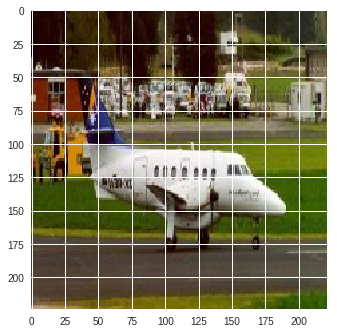

In [7]:
img,x = load_image("101_ObjectCategories/airplanes/image_0015.jpg")
print("shape of x: ",x.shape)
print("data type: ",x.dtype)
plt.imshow(img)

Import a random image from the dataset and pass it through the VGG16 neural net to see its predictions

In [8]:
predictions = model.predict(x)
# print(predictions)
for _, pred,prob in decode_predictions(predictions)[0]:
  print("predicted %s with probability %0.3f" %(pred,prob))

predicted airliner with probability 0.696
predicted wing with probability 0.235
predicted space_shuttle with probability 0.026
predicted warplane with probability 0.021
predicted airship with probability 0.015


Performing Feature Extraction on the existing model

In [9]:
feat_extractor = Model(inputs=model.input,outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

You can notice that the neural net now does not have the predictions layer.

Lets quickly see how the outputs of our new neural net look like when an image is passed through it

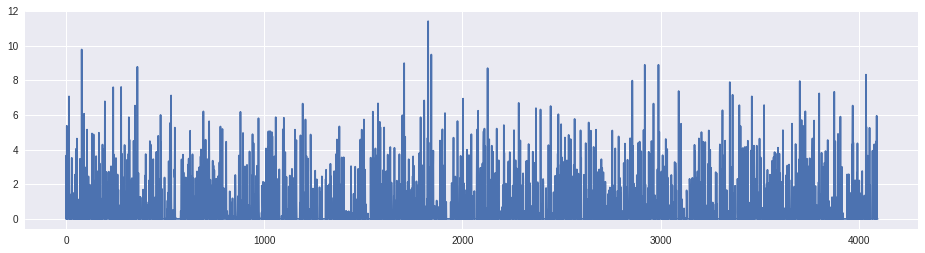

In [18]:
img,x = load_image("101_ObjectCategories/Leopards/image_0019.jpg")
feat = feat_extractor.predict(x)
plt.figure(figsize=(16,4))
plt.plot(feat[0])


As there is no Classification layer at the end,the outputs of the NN are just a bunch of activation values or more precisely the features of the input image which we will be using in next steps

In [11]:
images_path = '101_ObjectCategories'
image_extensions=['.jpg','.png','.jpeg']
max_num_images = 10000 #keep the number less than 30 if running on cpu for faster results
tick = time.time()
# dp has the root directory,dn has the sub directories and filenames has the file name

images = [os.path.join(dp,f) for dp,dn,filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images<len(images):
  #get random images from the image paths
  images = [images[i] for i in sorted(random.sample(range(len(images)),max_num_images))] #comment this and uncomment the below line if running on cpu to get better matches
#   images = images[0:max_num_images]
print("keeping %d images to analyze" %len(images))

keeping 9144 images to analyze


In [12]:

tic = time.time()
features = []
for i, image_path in enumerate(images):
  if i%500 == 0:
    toc = time.time()
    elap = toc-tic;
    print("analyzing image %d / %d. Time taken : %4.4f seconds"%(i,len(images),elap))
    tic= time.time()
  img,x = load_image(image_path)
  feat = feat_extractor.predict(x)[0]
  features.append(feat)
print('finished extracting features for %d images' % len(images))

analyzing image 0 / 9144. Time taken : 0.0001 seconds
analyzing image 500 / 9144. Time taken : 6.2018 seconds
analyzing image 1000 / 9144. Time taken : 6.3198 seconds
analyzing image 1500 / 9144. Time taken : 6.2408 seconds
analyzing image 2000 / 9144. Time taken : 6.2575 seconds
analyzing image 2500 / 9144. Time taken : 6.2538 seconds
analyzing image 3000 / 9144. Time taken : 6.3081 seconds
analyzing image 3500 / 9144. Time taken : 6.4493 seconds
analyzing image 4000 / 9144. Time taken : 6.2404 seconds
analyzing image 4500 / 9144. Time taken : 6.2990 seconds
analyzing image 5000 / 9144. Time taken : 6.1226 seconds
analyzing image 5500 / 9144. Time taken : 6.0557 seconds
analyzing image 6000 / 9144. Time taken : 6.0287 seconds
analyzing image 6500 / 9144. Time taken : 6.2354 seconds
analyzing image 7000 / 9144. Time taken : 6.6909 seconds
analyzing image 7500 / 9144. Time taken : 6.0691 seconds
analyzing image 8000 / 9144. Time taken : 6.7021 seconds
analyzing image 8500 / 9144. Time t

These Activations can be used as is, But its always a good idea to optimize both data loss and compute time when working with Neural Nets.

Here we use [Principle Component Analysis(PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimentionality of our feature vectors from 4096 down to 300 top principal components without much loss in information

In [13]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_features = pca.transform(features)


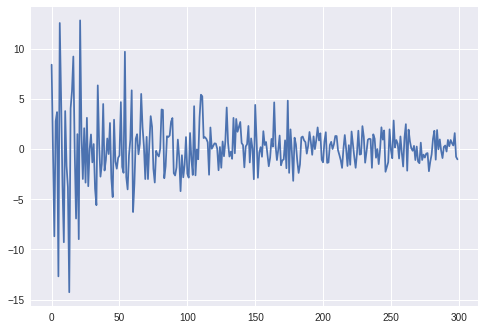

In [ ]:
plt.plot(pca_features[2])

In [ ]:
tock = time.time()
print(tock-tick)

Write a quick function to obtain the cosine distances of the query image from all the images in dataset then sort them to get top 5 closest images

In [0]:
from scipy.spatial import distance

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

Another quick function to merge all the closest images into a cascaded thumbnail,

**FYI ** : here we are using the images from the memory so no reference to the image filepaths

In [0]:
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'Result images')

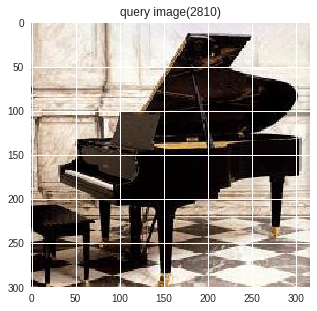

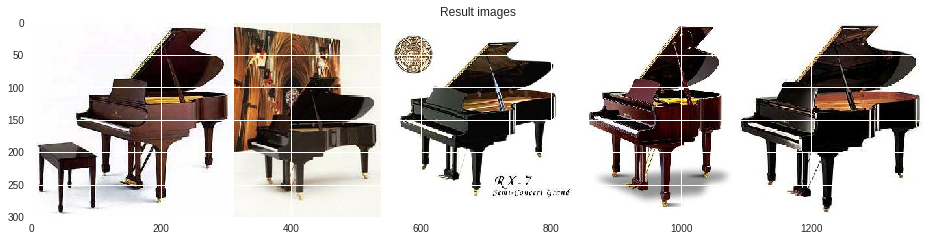

In [59]:
import random
query_image_idx = int(len(images)*random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx],300)
results_image = get_concatenated_images(idx_closest,300)

plt.figure(figsize=(5,5))
plt.imshow(query_image)
plt.title("query image(%d)" %query_image_idx)

plt.figure(figsize=(16,22))
plt.imshow(results_image)
plt.title("Result images")